<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 公園
- input:
    - 区ごとの公園の位置情報
- output:
    - park_score.csv
        - 公園スコア

In [66]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

     |████████████████████████████████| 96 kB 3.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [150]:
output_score_file = 'park_score.csv'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [67]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

def number_to_kanji(str):
    return str.translate(str.maketrans({
        '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九',
        '1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '7':'七', '8':'八', '9':'九', '0':'十', 
    }))

# 緯度経度取得
def add_lat_lon(df_master):
    lats = []
    lons = []
    for i, row in df_master.iterrows():
        chocho = number_to_kanji(row['町丁目'])
        ret = geocoder.osm('東京都' + row['市区町村名'] + chocho, timeout=5)
        if not ret.ok:
            print(i, row['市区町村名'], chocho)
        lats.append(ret.lat)
        lons.append(ret.lng)
    df_copy = df_master.copy()
    df_copy['緯度'] = lats
    df_copy['経度'] = lons
    return df_copy

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [60]:
def get_tokyo_ward_city(address):
    _tmp = address.replace('東京都', '')
    m = re.search('^.*?[区市]', _tmp)
    cityname = m.group()
    return cityname if len(cityname) < 6 else None

def get_category_facility(name):
    if re.search('.*公園$', name) is not None:
        return '公園'
    if re.search('.*緑地$', name) is not None:
        return '公園'
    if re.search('.*緑道$', name) is not None:
        return '公園'
    if re.search('.*庭園$', name) is not None:
        return '公園'
    if re.search('.*児童遊園$', name) is not None:
        return '公園'
    if re.search('.*図書館$', name) is not None:
        return '図書館'
    if re.search('.*美術館$', name) is not None:
        return '文化施設'
    if re.search('.*博物館$', name) is not None:
        return '文化施設'
    if re.search('.*会館$', name) is not None:
        return '文化施設'
    if re.search('.*劇場$', name) is not None:
        return '文化施設'
    if re.search('アーツ', name) is not None:
        return '文化施設'
    return None

In [7]:
def change_type(df_data):
    df_data['緯度'] = df_data['緯度'].astype(float)
    df_data['経度'] = df_data['経度'].astype(float)

In [13]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

## 0. 東京都
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t000003d0000000033/resource/27d1ce20-9023-4690-944c-5da47ed1427e)

In [113]:
tokyo_public_facility = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/130001_public_facility.csv'
df_tokyo_public_facility = get_data_csv_url(tokyo_public_facility, encoding='cp932')
print(df_tokyo_public_facility.shape)

df_tokyo_public_facility = df_tokyo_public_facility.rename(columns={'住所': '所在地'})
df_tokyo_public_facility['市区町村名'] = df_tokyo_public_facility['所在地'].apply(get_tokyo_ward_city)
df_tokyo_public_facility['施設分類'] = df_tokyo_public_facility['名称'].apply(get_category_facility)
df_tokyo_public_facility = df_tokyo_public_facility[extract_columns]
df_tokyo_public_facility = df_tokyo_public_facility[
    (df_tokyo_public_facility['施設分類']=='公園')&
    (df_tokyo_public_facility['市区町村名'].str.endswith('区'))
].reset_index(drop=True)
change_type(df_tokyo_public_facility)
print(df_tokyo_public_facility.shape)

(136, 39)
(80, 6)


## 1. 千代田区
- [公園・児童遊園・緑道](https://www.city.chiyoda.lg.jp/shisetsu/koen/index.html) -> CSVでない、数が少ない

## 2. 中央区
- [区内の公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131024d0000000011/resource/2cebf9bb-c082-41a4-973f-f39e81c20aa2)

In [89]:
chuou_park_url = 'https://www.city.chuo.lg.jp/kusei/statisticaldata/opendata.files/koenichiran.csv'
df_chuou_park = get_data_csv_url(chuou_park_url, encoding='shift-jis')
print(df_chuou_park.shape)

df_chuou_park['市区町村名'] = '中央区'
df_chuou_park['施設分類'] = '公園'
df_chuou_park = df_chuou_park.rename(columns={'住所':'所在地'})[extract_columns]
change_type(df_chuou_park)
print(df_chuou_park.shape)

(56, 5)
(56, 6)


## 3. 港区
- [公園・児童遊園・緑地](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014/resource/07c70d2b-0474-491c-a1f4-754b8f28922b)

In [90]:
minato_park_url = 'https://opendata.city.minato.tokyo.jp/dataset/dc609dcf-892a-4a20-8f74-f62ce9fc806d/resource/f636e5b8-088f-42e2-b95c-d0978d4e339c/download/minatokushisetsujoho_kouen.csv'
df_minato_park = get_data_csv_url(minato_park_url)
print(df_minato_park.shape)

df_minato_park['市区町村名'] = '港区'
df_minato_park['施設分類'] = '公園'
df_minato_park = df_minato_park[df_minato_park['第1分類'] == '公園・児童遊園・緑地'].reset_index(drop=False)
df_minato_park = df_minato_park.rename(columns={'ページタイトル':'名称'})[extract_columns]
change_type(df_minato_park)
print(df_minato_park.shape)

(157, 31)
(156, 6)


## 4. 新宿区
- [区立公園の一覧（五十音順）](http://www.city.shinjuku.lg.jp/seikatsu/midori01_001024.html) -> CSVでない

## 5. 文京区
- [区立公園・児童遊園・遊び場一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0509040001/resource/81688b74-8b82-4529-a1df-1d0ae73a808d)

In [91]:
bunkyo_park_url = 'https://www.city.bunkyo.lg.jp/library/opendata-bunkyo/05bousai-macidukuri-kankyou/03kouen-asobiba/kuritsukouen-jidouyuuen-asobiba.csv'
df_bunkyo_park = get_data_csv_url(bunkyo_park_url, encoding='shift-jis')
print(df_bunkyo_park.shape)

df_bunkyo_park['市区町村名'] = '文京区'
df_bunkyo_park['施設分類'] = '公園'
df_bunkyo_park = df_bunkyo_park.rename(columns={'施設名':'名称', '住所':'所在地'})[extract_columns]
change_type(df_bunkyo_park)
print(df_bunkyo_park.shape)

(119, 10)
(119, 6)


## 6. 台東区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000093/resource/c70f81da-7c29-497a-ab55-068686d75707)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000094/resource/5d61c7a3-573d-4a27-8492-6e299f2fe401)

In [92]:
taito_park_url_1 = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_15.csv'
df_taito_park_1 = get_data_csv_url(taito_park_url_1, 'shift-jis')
taito_park_url_2 = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_16.csv'
df_taito_park_2 = get_data_csv_url(taito_park_url_2, 'shift-jis')
df_taito_park = pd.concat([df_taito_park_1, df_taito_park_2]).reset_index(drop=True)
print(df_taito_park.shape)

df_taito_park['市区町村名'] = '台東区'
df_taito_park['施設分類'] = '公園'
df_taito_park = df_taito_park.rename(columns={'X座標':'経度', 'Y座標':'緯度'})[extract_columns]
print(df_taito_park.shape)

(83, 8)
(83, 6)


## 7. 墨田区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/ea22e8d7-677a-4ab8-b231-f5d309fd0be6)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/21a0e89e-ee2f-4bf0-90db-b70ebb77453e)

In [93]:
sumida_park_url_1 = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/park.csv'
df_sumida_park_1 = get_data_csv_url(sumida_park_url_1, 'shift-jis')
sumida_park_url_2 = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/jidouyuuen.csv'
df_sumida_park_2 = get_data_csv_url(sumida_park_url_2, 'shift-jis')
df_sumida_park = pd.concat([df_sumida_park_1, df_sumida_park_2]).reset_index(drop=True)
print(df_sumida_park.shape)

df_sumida_park['市区町村名'] = '墨田区'
df_sumida_park['施設分類'] = '公園'
df_sumida_park = df_sumida_park.rename(columns={'施設名称':'名称'})[extract_columns]
print(df_sumida_park.shape)

(144, 5)
(144, 6)


## 8. 江東区
- [区立公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/204f8626-3307-48e3-9d2c-03d38aa732f1)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/cef3a8af-0006-4341-a0ab-a62b26a5a28c)

In [94]:
koutou_park_url = 'https://www.city.koto.lg.jp/012107/documents/131083_kotocity_public_facility-17_parks.csv'
df_koutou_park = get_data_csv_url(koutou_park_url, encoding='shift-jis')
print(df_koutou_park.shape)

df_koutou_park['市区町村名'] = '江東区'
df_koutou_park['施設分類'] = '公園'
df_koutou_park = df_koutou_park.rename(columns={'施設名':'名称', '住所':'所在地'})[extract_columns]
change_type(df_koutou_park)
print(df_koutou_park.shape)

(171, 39)
(171, 6)


## 9. 品川区
- [公共施設csvデータ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131091d0000000003/resource/739098b6-e043-41ad-9b5b-f83481d09631)

In [95]:
url_shinagawa_facility = 'http://www.city.shinagawa.tokyo.jp/ct/other000081600/kokyoshisetsu.csv'
df_shinagawa_facility = get_data_csv_url(url_shinagawa_facility, encoding='cp932')
print(df_shinagawa_facility.shape)

df_shinagawa_facility = df_shinagawa_facility.rename(columns={'住所': '所在地', '施設名':'名称', '説明(日本語)':'施設分類'})
df_shinagawa_facility['市区町村名'] = '品川区'
df_shinagawa_facility = df_shinagawa_facility[extract_columns]
df_shinagawa_facility = df_shinagawa_facility[
    (df_shinagawa_facility['施設分類'].isin(['公園', '児童遊園', '水辺広場']))
].reset_index(drop=True)
df_shinagawa_facility['施設分類'] = '公園'
change_type(df_shinagawa_facility)
print(df_shinagawa_facility.shape)

(758, 20)
(219, 6)


## 10. 目黒区
- [区立公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131105d0000000038/resource/1264013c-5458-409e-95be-208f0d78d51b)

In [96]:
megro_park_url = 'https://data.bodik.jp/dataset/9f7d70e4-d41f-4199-a180-eb2e3de6e728/resource/28badfb6-f33f-4b12-8ecc-ada279950cee/download/131105_park_20210401.csv'
df_megro_park = get_data_csv_url(megro_park_url, 'cp932')
print(df_megro_park.shape)

df_megro_park['市区町村名'] = '目黒区'
df_megro_park['施設分類'] = '公園'
df_megro_park = df_megro_park[df_megro_park['面積（㎡）'] >= 500][extract_columns].reset_index(drop=True)
change_type(df_megro_park)
print(df_megro_park.shape)

(73, 23)
(44, 6)


## 11. 大田区
- [公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131113d0000000018/resource/6af8376d-0dc9-47f0-ad66-dd7e612f929c) -> Excelで緯度経度がない

## 12. 世田谷区
- [トイレのある公園、身近な広場等一覧](https://www.city.setagaya.lg.jp/mokuji/kusei/012/015/001/001/d00192981.html) -> CSVでない

## 13. 渋谷区
- [公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131130d0000000003/resource/46345b46-4f99-4342-abba-aabd6029bbb6)

In [97]:
shibuya_park_url = 'https://www.city.shibuya.tokyo.jp/assets/mng/131130_park.csv'
df_shibuya_park = get_data_csv_url(shibuya_park_url)
print(df_shibuya_park.shape)

df_shibuya_park['施設分類'] = '公園'
df_shibuya_park = df_shibuya_park.rename(columns={'住所': '所在地'})
df_shibuya_park = df_shibuya_park[df_shibuya_park['面積（平方メートル）'] >= 500][extract_columns].reset_index(drop=True)
change_type(df_shibuya_park)
print(df_shibuya_park.shape)

(127, 17)
(66, 6)


## 14. 中野区
- [中野区オープンデータ 公共施設一覧（公園等）](https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582.html)

In [98]:
nakano_park_url = 'https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582_d/fil/131148_public_facility_k.csv'
df_nakano_park = get_data_csv_url(nakano_park_url)
print(df_nakano_park.shape)

df_nakano_park['施設分類'] = '公園'
df_nakano_park = df_nakano_park.rename(columns={'住所': '所在地'})
df_nakano_park = df_nakano_park[extract_columns]
change_type(df_nakano_park)
print(df_nakano_park.shape)

(188, 39)
(188, 6)


## 15. 杉並区
- [オープンデータ一覧](https://www2.wagmap.jp/suginami/opendata?type=shp&ly=930)

In [99]:
df_suginami_park = pd.read_csv(os.path.join(DIR_NAME, 'original/杉並区_公園.csv'))
print(df_suginami_park.shape)

df_suginami_park = df_suginami_park[df_suginami_park['分類'].str.strip() == '公園']
df_suginami_park['市区町村名'] = '杉並区'
df_suginami_park['施設分類'] = '公園'
df_suginami_park = df_suginami_park.rename(columns={'住所':'所在地'})[extract_columns]
print(df_suginami_park.shape)

(357, 9)
(335, 6)


## 16. 豊島区
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131164d0000000010/resource/472e6a97-b350-4909-a939-76530a570324)

In [100]:
url_toshima_facility = 'https://www.opendata.metro.tokyo.lg.jp/toyoshima/R4_public_facility.csv'
df_toshima_facility = get_data_csv_url(url_toshima_facility, encoding='cp932')
print(df_toshima_facility.shape)

df_toshima_facility = df_toshima_facility.rename(columns={'住所': '所在地'})
df_toshima_facility['施設分類'] = df_toshima_facility['名称'].apply(get_category_facility)
df_toshima_facility = df_toshima_facility[extract_columns]
df_toshima_facility = df_toshima_facility[
    (df_toshima_facility['施設分類'] == '公園')
].reset_index(drop=True)
change_type(df_toshima_facility)
print(df_toshima_facility.shape)

(538, 24)
(160, 6)


## 17. 北区
- [公園案内（北区内の公園・児童遊園）](https://www.city.kita.tokyo.jp/d-douro/jutaku/koen/annai.html) -> CSVでない

## 18. 荒川区
- [公園](https://www.city.arakawa.tokyo.jp/koen/koen/index.html) -> 一覧はない

## 19. 板橋区
- [公園・公衆便所オープンデータ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000001151/resource/8bfab687-375e-4634-b1f6-dca56b34fe4c)
- [どこでも誰でもおでかけマップオープンデータ（公園）](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000000767/resource/c56d0887-9536-4c92-a965-8ee0a94d28a5)

In [101]:
url_itabashi_park = 'https://www.city.itabashi.tokyo.jp/_res/projects/default_project/_page_/001/014/717/20200401.xlsx'
df_itabashi_park = get_data_csv_url(url_itabashi_park, excel=True)
print(df_itabashi_park.shape)

df_itabashi_park['市区町村名'] = '板橋区'
df_itabashi_park['施設分類'] = '公園'
df_itabashi_park = df_itabashi_park.rename(columns={'住所':'所在地'})[extract_columns]
change_type(df_itabashi_park)
print(df_itabashi_park.shape)

(230, 20)
(230, 6)


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## 20. 練馬区
- [その他区立公園など（公園等一覧）](https://www.city.nerima.tokyo.jp/kankomoyoshi/annai/fukei/nerima_park/kunai/kouen-itiran.html) -> CSVでない

In [103]:
%%time
df_nerima_park = pd.read_csv(os.path.join(DIR_NAME, 'original/練馬区_公園.csv'))
print(df_nerima_park.shape)

df_nerima_park = df_nerima_park[df_nerima_park['所在地'].notna()].reset_index(drop=True)
df_nerima_park['市区町村名'] = '練馬区'
df_nerima_park['施設分類'] = '公園'
df_nerima_park['町丁目'] = df_nerima_park['所在地'].apply(lambda x: x.split('-')[0]+'丁目')
df_nerima_park['面積'] = df_nerima_park['面積'].str.replace(',', '').astype(float)
df_nerima_park = df_nerima_park[df_nerima_park['面積'] >= 500]  # 面積の小さい公園は除く
df_nerima_park = df_nerima_park.rename(columns={'園名':'名称'})

df_nerima_park = add_lat_lon(df_nerima_park)[extract_columns].reset_index(drop=True)
print(df_nerima_park.shape)

(734, 3)
163 練馬区 栄町四十丁目
357 練馬区 立野町一八丁目
359 練馬区 立野町三二丁目
(309, 6)
CPU times: user 3.93 s, sys: 232 ms, total: 4.16 s
Wall time: 2min 34s


## 21. 足立区
- [公園・児童遊園・プチテラス・便所のデータ](https://www.city.adachi.tokyo.jp/t-iji/kouenbinran.html) -> 緯度経度がない

## 22. 葛飾区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131229d0000000002/resource/8b0d0b9c-ea4f-40e0-af24-fea29078bc0e)

In [86]:
url_katsushika_park = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/131229__public_facility_6.csv'
df_katsushika_park = get_data_csv_url(url_katsushika_park, encoding='shift-jis')
df_katsushika_park = df_katsushika_park.dropna(how='all')
print(df_katsushika_park.shape)

df_katsushika_park = df_katsushika_park[df_katsushika_park['データセット名'].notna()].reset_index(drop=True)
df_katsushika_park['施設分類'] = '公園'
df_katsushika_park = df_katsushika_park.rename(columns={'名称（例）':'名称', '住所':'所在地', '軽度':'経度'})[extract_columns]
change_type(df_katsushika_park)
print(df_katsushika_park.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (2,3,4,5,7,8,9,12,20,22,24,25,39) have mixed types.Specify dtype option on import or set low_memory=False.
  


(26, 40)
(25, 6)


## 23. 江戸川区
- [公園・親水公園・動物園](https://www.city.edogawa.tokyo.jp/e066/kuseijoho/gaiyo/shisetsuguide/bunya/koendobutsuen/index.html) -> CSVでない

## 公園マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都|済み|
|1|千代田区| |
|2|中央区|済み|
|3|港区|済み|
|4|新宿区| |
|5|文京区|済み|
|6|台東区|済み|
|7|墨田区|済み|
|8|江東区|済み|
|9|品川区|済み|
|10|目黒区|済み|
|11|大田区| |
|12|世田谷区| |
|13|渋谷区|済み|
|14|中野区|済み|
|15|杉並区|済み|
|16|豊島区|済み|
|17|北区| |
|18|荒川区| |
|19|板橋区|済み|
|20|練馬区|済み|
|21|足立区| |
|22|葛飾区|済み|
|23|江戸川区| |


In [114]:
df_park_master = pd.concat([
    df_tokyo_public_facility,
    df_chuou_park,
    df_minato_park,
    df_bunkyo_park,
    df_taito_park,
    df_sumida_park,
    df_koutou_park,
    df_shinagawa_facility,
    df_megro_park,
    df_shibuya_park,
    df_nakano_park,
    df_suginami_park,
    df_toshima_facility,
    df_itabashi_park,
    df_nerima_park,
    df_katsushika_park,
]).reset_index(drop=True)
print(df_park_master.shape)

(2385, 6)


In [115]:
df_park_master.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,公園,お台場海浜公園,港区,東京都港区台場一丁目４番地,35.630845,139.776087
1,公園,シンボルプロムナード公園,港区,東京都港区台場一丁目・二丁目、江東区青海一丁目・二丁目、有明二丁目・三丁目,35.623908,139.774430
2,公園,東八潮緑道公園,品川区,東京都品川区東八潮,35.619315,139.771579
3,公園,青海北ふ頭公園,江東区,東京都江東区青海二丁目,35.618915,139.773785
4,公園,青海南ふ頭公園,江東区,東京都江東区青海二丁目,35.615663,139.776117


In [116]:
df_park_master.to_csv(os.path.join(DIR_NAME, 'park_master.csv'), index=False)

In [118]:
# データがある区をリストアップ
sr_park_count = df_park_master[df_park_master['施設分類'] == '公園']['市区町村名'].value_counts()
ward_list = list(sr_park_count[sr_park_count > 10].index)
print(len(ward_list))

15


## 人口マスタ

In [140]:
population = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(population.shape)
df_pop_master = population[population['市区町村名'].isin(ward_list)][['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']].reset_index(drop=True)
print(df_pop_master.shape)

(3145, 32)
(1750, 6)


In [141]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

## 公園スコア

In [142]:
%%time
# 近い5件の距離の平均
df_pop_master['公園(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_park_master, '公園', 'mean', 5)
# 1km以内の施設の数
df_pop_master['公園(数)'] = get_value_of_nearest_facility(df_pop_master, df_park_master, '公園', 'count', 1)

CPU times: user 2min 17s, sys: 339 ms, total: 2min 17s
Wall time: 2min 22s


In [143]:
print(df_pop_master.shape)
df_pop_master.head()

(1750, 8)


,地域ID,市区町村名,町名,町丁目,緯度,経度,公園(平均距離),公園(数)
0,102002,中央区,八重洲２丁目,八重洲２丁目,35.677869,139.768534,0.739098,9
1,102004,中央区,京橋,京橋１丁目,35.678156,139.772672,0.583289,10
2,102005,中央区,京橋,京橋２丁目,35.676659,139.771529,0.603255,12
3,102006,中央区,京橋,京橋３丁目,35.675439,139.770196,0.633105,12
4,102008,中央区,銀座,銀座１丁目,35.674347,139.767033,0.728927,8


In [144]:
score_name = '公園スコア'
feature_list = {
    '公園(平均距離)':       {'high': False, 'outlier': True, 'weight': 1}, 
    '公園(数)':             {'high': True, 'outlier': False, 'weight': 1},
}

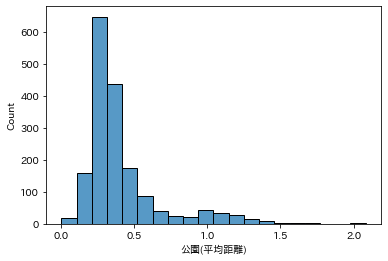

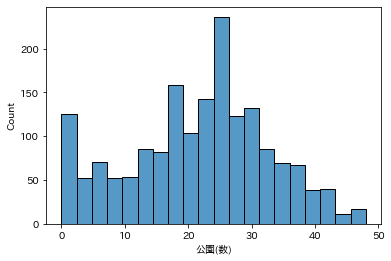

In [145]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

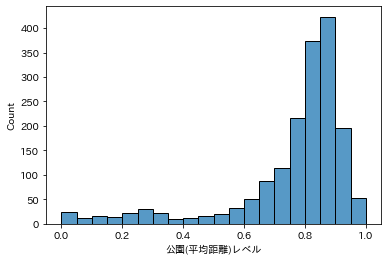

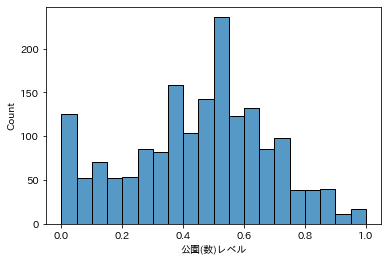

In [146]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

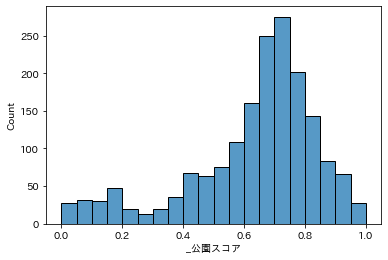

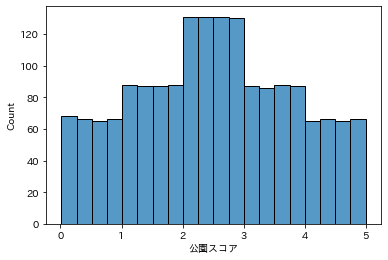

In [147]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

In [148]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,緯度,経度,公園(平均距離),公園(数),公園(平均距離)レベル,公園(数)レベル,_公園スコア,公園スコア
0,102002,中央区,八重洲２丁目,八重洲２丁目,35.677869,139.768534,0.739098,9,0.495487,0.187500,0.357888,0.751335
1,102004,中央区,京橋,京橋１丁目,35.678156,139.772672,0.583289,10,0.617917,0.208333,0.432958,1.016590
2,102005,中央区,京橋,京橋２丁目,35.676659,139.771529,0.603255,12,0.602228,0.250000,0.446570,1.076659
3,102006,中央区,京橋,京橋３丁目,35.675439,139.770196,0.633105,12,0.578773,0.250000,0.434280,1.030892
4,102008,中央区,銀座,銀座１丁目,35.674347,139.767033,0.728927,8,0.503479,0.166667,0.351159,0.736079


## 保存

In [151]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + list(feature_list.keys()) + total_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

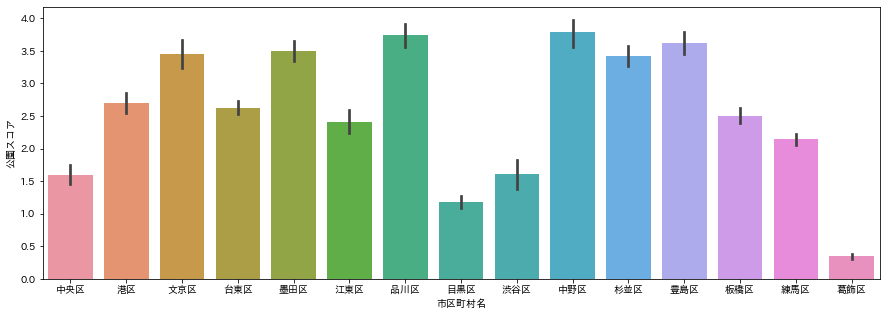

In [152]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [153]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + total_score_list + list(feature_list.keys())
].reset_index(drop=True)
print(df_level.shape)

(478, 7)


In [154]:
df_level.head(20)

,市区町村名,町名,町丁目,_公園スコア,公園スコア,公園(平均距離),公園(数)
0,墨田区,東向島,東向島６丁目,1.000000,5.000000,0.187113,47
1,中野区,中央,中央５丁目,0.999867,4.996186,0.187436,47
2,品川区,東中延,東中延１丁目,0.988299,4.992372,0.242044,48
3,中野区,中野,中野３丁目,0.983566,4.984744,0.200512,46
4,品川区,平塚,平塚２丁目,0.983310,4.980931,0.227649,47
5,品川区,戸越,戸越６丁目,0.981505,4.969489,0.205519,46
6,品川区,中延,中延１丁目,0.981299,4.965675,0.206020,46
7,杉並区,荻窪,荻窪１丁目,0.979132,4.961861,0.237796,47
8,品川区,北品川,北品川２丁目,0.978417,4.958047,0.186505,45
9,墨田区,八広,八広１丁目,0.971309,4.954233,0.150740,43


In [155]:
df_level.tail(20)

,市区町村名,町名,町丁目,_公園スコア,公園スコア,公園(平均距離),公園(数)
458,葛飾区,宝町,宝町１丁目,0.203050,0.530130,0.982584,4
459,葛飾区,小菅,小菅２丁目,0.202246,0.526316,0.931511,2
460,葛飾区,白鳥,白鳥４丁目,0.180719,0.461480,1.010305,3
461,葛飾区,東水元,東水元３丁目,0.179288,0.457666,0.987267,2
462,葛飾区,高砂,高砂８丁目,0.173337,0.450038,1.028234,3
463,葛飾区,亀有,亀有２丁目,0.170777,0.446224,1.007939,2
464,葛飾区,奥戸,奥戸７丁目,0.169982,0.442410,1.036384,3
465,葛飾区,水元,水元３丁目,0.169715,0.438596,1.010517,2
466,葛飾区,青戸,青戸４丁目,0.167568,0.427155,1.015733,2
467,葛飾区,金町浄水場,金町浄水場,0.167562,0.423341,1.015747,2
